## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, kstest
from scipy.stats import f_oneway, kruskal, bartlett, levene
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

plt.rcParams.update({
    'axes.facecolor': '#212121',
    'figure.facecolor': '#1f1f1f',
    'axes.edgecolor': 'white',
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})

BLUE = '#1cb1fc'
RED = '#ff5107'
GREEN = '#00ff00'

### Utility functions

In [2]:
# Check if the data is normally distributed
def is_normal(data):
    if len(data) < 50:
        _, p = shapiro(data)
    else:
        _, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    return p > 0.05

# Perform either t-test or mann whitney
def perform_test(group1, group2, test_type):
    if test_type == 't-test':
        stat, p = ttest_ind(group1, group2, equal_var=False)
    else:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    return stat, p

# Is the variance equal?
def variance_test(data, normal):
    if normal:
        stat, p = bartlett(*data)
    else:
        stat, p = levene(*data)
    return p > 0.05

# Perform ANOVA or Kruskal
def perform_anova_kruskal(groups, test_type):
    if test_type == 'ANOVA':
        stat, p = f_oneway(*groups)
    else:
        stat, p = kruskal(*groups)
    return stat, p

#### Importing the datasets

In [3]:
circuits = pd.read_csv('./f1_dataset/circuits.csv')
constructor_results = pd.read_csv('./f1_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('./f1_dataset/constructor_standings.csv')
constructors = pd.read_csv('./f1_dataset/constructors.csv')
driver_standings = pd.read_csv('./f1_dataset/driver_standings.csv')
drivers = pd.read_csv('./f1_dataset/drivers.csv')
lap_times = pd.read_csv('./f1_dataset/lap_times.csv')
pit_stops = pd.read_csv('./f1_dataset/pit_stops.csv')
qualifying = pd.read_csv('./f1_dataset/qualifying.csv')
races = pd.read_csv('./f1_dataset/races.csv')
results = pd.read_csv('./f1_dataset/results.csv')
seasons = pd.read_csv('./f1_dataset/seasons.csv')
sprint_results = pd.read_csv('./f1_dataset/sprint_results.csv')
status = pd.read_csv('./f1_dataset/status.csv')

In [4]:
print("circuits: ", ', '.join(circuits.columns.to_list()))
print("constructor_results: ", ', '.join(constructor_results.columns.to_list()))
print("constructor_standings: ", ', '.join(constructor_standings.columns.to_list()))
print("constructors: ", ', '.join(constructors.columns.to_list()))
print("driver_standings: ", ', '.join(driver_standings.columns.to_list()))
print("drivers: ", ', '.join(drivers.columns.to_list()))
print("lap_times: ", ', '.join(lap_times.columns.to_list()))
print("pit_stops: ", ', '.join(pit_stops.columns.to_list()))
print("qualifying: ", ', '.join(qualifying.columns.to_list()))
print("races: ", ', '.join(races.columns.to_list()))
print("results: ", ', '.join(results.columns.to_list()))
print("seasons: ", ', '.join(seasons.columns.to_list()))
print("sprint_results: ", ', '.join(sprint_results.columns.to_list()))
print("status: ", ', '.join(status.columns.to_list()))

circuits:  circuitId, circuitRef, name, location, country, lat, lng, alt, url
constructor_results:  constructorResultsId, raceId, constructorId, points, status
constructor_standings:  constructorStandingsId, raceId, constructorId, points, position, positionText, wins
constructors:  constructorId, constructorRef, name, nationality, url
driver_standings:  driverStandingsId, raceId, driverId, points, position, positionText, wins
drivers:  driverId, driverRef, number, code, forename, surname, dob, nationality, url
lap_times:  raceId, driverId, lap, position, time, milliseconds
pit_stops:  raceId, driverId, stop, lap, time, duration, milliseconds
qualifying:  qualifyId, raceId, driverId, constructorId, number, position, q1, q2, q3
races:  raceId, year, round, circuitId, name, date, time, url, fp1_date, fp1_time, fp2_date, fp2_time, fp3_date, fp3_time, quali_date, quali_time, sprint_date, sprint_time
results:  resultId, raceId, driverId, constructorId, number, grid, position, positionText, p

## Let's take a look into Dataset

We need to figure out what all of the variables exactly mean.

In [5]:
# points = Points at the end of the race
# position = Position in the standings at the end of the race
# wins = Race wins at the end of the race

driver_standings.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


#### Take a look at Verstappen for example

In [6]:
drivers[drivers["surname"] == "Verstappen"]

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
49,50,verstappen,\N,\N,Jos,Verstappen,1972-03-04,Dutch,http://en.wikipedia.org/wiki/Jos_Verstappen
829,830,max_verstappen,33,VER,Max,Verstappen,1997-09-30,Dutch,http://en.wikipedia.org/wiki/Max_Verstappen


In [7]:
driver_standings[driver_standings["driverId"] == 830]

,driverStandingsId,raceId,driverId,points,position,positionText,wins
6315,68160,969,830,10.0,5,5,0
30392,67196,926,830,0.0,13,13,0
30416,67070,927,830,6.0,10,10,0
30437,67091,928,830,6.0,11,11,0
30458,67112,929,830,6.0,11,11,0
...,...,...,...,...,...,...,...
34505,72767,1128,830,169.0,1,1,5
34511,72788,1129,830,194.0,1,1,6
34532,72809,1130,830,219.0,1,1,7
34553,72830,1131,830,237.0,1,1,7


In [8]:
ver_standings = driver_standings[driver_standings["driverId"] == 830]
ver_standings_year = ver_standings.merge(races, on='raceId')[["driverStandingsId", "raceId", "driverId", "points", "position", "wins", "year"]]
ver_standings_year.head()

,driverStandingsId,raceId,driverId,points,position,wins,year
0,68160,969,830,10.0,5,0,2017
1,67196,926,830,0.0,13,0,2015
2,67070,927,830,6.0,10,0,2015
3,67091,928,830,6.0,11,0,2015
4,67112,929,830,6.0,11,0,2015


#### Verstappen statistics

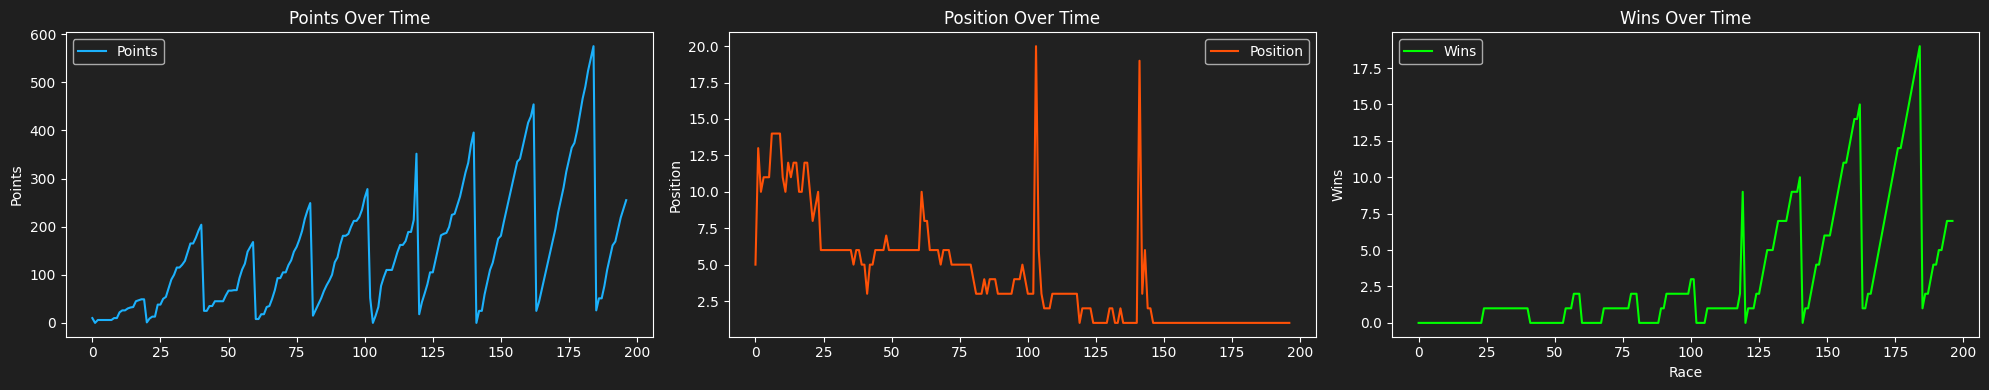

In [9]:
ver_points = ver_standings_year["points"]
ver_position = ver_standings_year["position"]
ver_wins = ver_standings_year["wins"]

fig, axs = plt.subplots(1, 3, figsize=(20, 4))

# Points
axs[0].plot(ver_points, label='Points', color=BLUE)
axs[0].set_title('Points Over Time')
axs[0].set_ylabel('Points')
axs[0].legend()

# Position
axs[1].plot(ver_position, label='Position', color=RED)
axs[1].set_title('Position Over Time')
axs[1].set_ylabel('Position')
axs[1].legend()

# Wins
axs[2].plot(ver_wins, label='Wins', color=GREEN)
axs[2].set_title('Wins Over Time')
axs[2].set_ylabel('Wins')
axs[2].legend()

plt.xlabel('Race')
plt.tight_layout()
plt.show()

In [10]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


## Filter

We will certainly need the following variables:
 - driver_standings: driverId, **points**
 - drivers: driverId, **forename**, **surname**
 - lap_times: raceId, driverId, **lap**, **position**, **milliseconds**
 - races: raceId, **year**, **circuitId**
 - results: raceId, driveId, **grid**, **position**, **points**, **laps**, **milliseconds**, **rank**, **statusId**

In [11]:
YEAR_THRESHOLD = 2014 # Take only greater than this
MIN_NUM_RACES = 10 # Take only drivers that has at least this amount of races in the period

In [12]:
races_filtered = races[races["year"] >= YEAR_THRESHOLD][["raceId", "year", "circuitId"]]
print("Number of races: ", len(races_filtered))

Number of races:  228


In [13]:
merged = results.merge(races_filtered, on='raceId', how='inner')

In [14]:
merged

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,circuitId
0,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1
1,22131,900,825,1,20,4,2,2,2,18.0,57,+26.777,5605487,49,6,1:33.066,205.131,1,2014,1
2,22132,900,18,1,22,10,3,3,3,15.0,57,+30.027,5608737,39,5,1:32.917,205.460,1,2014,1
3,22133,900,4,6,14,5,4,4,4,12.0,57,+35.284,5613994,57,7,1:33.186,204.867,1,2014,1
4,22134,900,822,3,77,15,5,5,5,10.0,57,+47.639,5626349,56,3,1:32.616,206.128,1,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,26520,1132,839,214,31,18,16,16,16,0.0,50,\N,\N,46,16,1:30.875,233.371,12,2024,9
4382,26521,1132,815,9,11,0,17,17,17,0.0,50,\N,\N,50,6,1:29.707,236.409,12,2024,9
4383,26522,1132,855,15,24,14,18,18,18,0.0,50,\N,\N,43,17,1:31.014,233.014,12,2024,9
4384,26523,1132,847,131,63,1,\N,R,19,0.0,33,\N,\N,3,19,1:31.298,232.289,34,2024,9


In [15]:
driver_race_counts = merged["driverId"].value_counts()
print("All drivers:", len(driver_race_counts))
display(driver_race_counts[:10])

All drivers: 57


driverId
822    216
1      215
815    214
817    201
830    197
832    196
20     180
825    176
4      175
807    160
Name: count, dtype: int64

In [16]:
top_10_driver_ids = driver_race_counts.head(10).index
top_10_drivers_most_races = drivers[drivers["driverId"].isin(top_10_driver_ids)][["driverId", "forename", "surname"]]
top_10_drivers_most_races = top_10_drivers_most_races.merge(driver_race_counts.head(10).rename("num_races"), left_on="driverId", right_index=True)
top_10_drivers_most_races = top_10_drivers_most_races.sort_values("num_races", ascending=False)
display(top_10_drivers_most_races)

,driverId,forename,surname,num_races
821,822,Valtteri,Bottas,216
0,1,Lewis,Hamilton,215
814,815,Sergio,Pérez,214
816,817,Daniel,Ricciardo,201
829,830,Max,Verstappen,197
831,832,Carlos,Sainz,196
19,20,Sebastian,Vettel,180
824,825,Kevin,Magnussen,176
3,4,Fernando,Alonso,175
807,807,Nico,Hülkenberg,160


In [17]:
eligible_drivers = driver_race_counts[driver_race_counts >= MIN_NUM_RACES].index
print(f"From {len(driver_race_counts)} to {len(eligible_drivers)}")
print(f"{len(driver_race_counts) - len(eligible_drivers)} drivers have less than {MIN_NUM_RACES} number of races.")

final_filtered_results = merged[merged["driverId"].isin(eligible_drivers)]

From 57 to 50
7 drivers have less than 10 number of races.


In [18]:
final_filtered_results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,circuitId
0,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1
1,22131,900,825,1,20,4,2,2,2,18.0,57,+26.777,5605487,49,6,1:33.066,205.131,1,2014,1
2,22132,900,18,1,22,10,3,3,3,15.0,57,+30.027,5608737,39,5,1:32.917,205.460,1,2014,1
3,22133,900,4,6,14,5,4,4,4,12.0,57,+35.284,5613994,57,7,1:33.186,204.867,1,2014,1
4,22134,900,822,3,77,15,5,5,5,10.0,57,+47.639,5626349,56,3,1:32.616,206.128,1,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,26520,1132,839,214,31,18,16,16,16,0.0,50,\N,\N,46,16,1:30.875,233.371,12,2024,9
4382,26521,1132,815,9,11,0,17,17,17,0.0,50,\N,\N,50,6,1:29.707,236.409,12,2024,9
4383,26522,1132,855,15,24,14,18,18,18,0.0,50,\N,\N,43,17,1:31.014,233.014,12,2024,9
4384,26523,1132,847,131,63,1,\N,R,19,0.0,33,\N,\N,3,19,1:31.298,232.289,34,2024,9


## Driver ELO Analysis

In [19]:
initial_rating = 1500
K = 30

In [20]:
elo_ratings = {
    -1 : {driver_id: initial_rating for driver_id in final_filtered_results["driverId"].unique()}
}

In [21]:
def update_elo(race_results, elo_ratings, K=30):
    for i, driver_1 in enumerate(race_results):
        for j, driver_2 in enumerate(race_results):
            if i != j:
                # Calculate expected scores
                R1 = elo_ratings[driver_1]
                R2 = elo_ratings[driver_2]
                E1 = 1 / (1 + 10 ** ((R2 - R1) / 400))
                E2 = 1 / (1 + 10 ** ((R1 - R2) / 400))
                
                # Assign score (1 for win, 0 for loss)
                S1 = 1 if i < j else 0
                S2 = 1 - S1
                
                # Update ratings
                elo_ratings[driver_1] += K * (S1 - E1)
                elo_ratings[driver_2] += K * (S2 - E2)
    
    return elo_ratings

In [22]:
for race_id, race_data in final_filtered_results.groupby('raceId'):
    race_results = race_data.sort_values('positionOrder')['driverId'] # Driver IDs sorted by race position
    last = sorted(elo_ratings.keys(), reverse=True)[0]
    elo_ratings[race_id] = update_elo(race_results, elo_ratings[last].copy())

In [23]:
tmp = elo_ratings.pop(-1)

In [24]:
sorted(elo_ratings.keys())[:10]

[900, 901, 902, 903, 904, 905, 906, 907, 908, 909]

In [25]:
last = sorted(elo_ratings.keys(), reverse=True)[0]
elo_last_df = pd.DataFrame(list(elo_ratings[last].items()), columns=["driverId", "elo_rating"])

In [26]:
elo_last_names_df = elo_last_df.merge(drivers, on='driverId')[["driverId", "elo_rating", "forename", "surname"]]
elo_last_names_df = elo_last_names_df.merge(driver_race_counts, on='driverId')

In [27]:
display(elo_last_names_df.sort_values(by="elo_rating", ascending=False).reset_index()[["driverId", "elo_rating", "forename", "surname", "count"]])

,driverId,elo_rating,forename,surname,count
0,3,2342.845757,Nico,Rosberg,59
1,830,2274.853678,Max,Verstappen,197
2,1,2262.652504,Lewis,Hamilton,215
3,857,2138.338287,Oscar,Piastri,34
4,832,2040.385521,Carlos,Sainz,196
5,807,1920.506078,Nico,Hülkenberg,160
6,846,1888.474757,Lando,Norris,116
7,840,1791.724901,Lance,Stroll,156
8,4,1694.682140,Fernando,Alonso,175
9,13,1683.073103,Felipe,Massa,78


In [28]:
all_races_elo = pd.DataFrame()

for race_id in elo_ratings.keys():
    # ELO after individual race
    race_elo = pd.DataFrame(list(elo_ratings[race_id].items()), columns=["driverId", "elo_rating"])
    race_elo['raceId'] = race_id
    all_races_elo = pd.concat([all_races_elo, race_elo], ignore_index=True)

In [29]:
display(all_races_elo[:20])

,driverId,elo_rating,raceId
0,3,1778.820655,900
1,825,1757.178055,900
2,18,1735.290282,900
3,4,1713.069319,900
4,822,1690.430154,900
5,807,1667.288194,900
6,8,1643.556853,900
7,818,1619.145184,900
8,826,1593.955452,900
9,815,1567.880576,900


### Features

In [30]:
filtered_with_lap_times = final_filtered_results.merge(lap_times, on=['raceId', 'driverId'])
display(filtered_with_lap_times)

,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,laps,time_x,milliseconds_x,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,circuitId,lap,position_y,time_y,milliseconds_y
0,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1,1,1,1:42.038,102038
1,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1,2,1,1:37.687,97687
2,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1,3,1,1:35.765,95765
3,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1,4,1,1:34.939,94939
4,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,2014,1,5,1,1:35.438,95438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233154,26504,1131,846,1,4,2,20,20,20,0.0,64,\N,\N,53,3,1:08.016,228.546,17,2024,70,60,2,1:09.356,69356
233155,26504,1131,846,1,4,2,20,20,20,0.0,64,\N,\N,53,3,1:08.016,228.546,17,2024,70,61,2,1:10.037,70037
233156,26504,1131,846,1,4,2,20,20,20,0.0,64,\N,\N,53,3,1:08.016,228.546,17,2024,70,62,2,1:09.509,69509
233157,26504,1131,846,1,4,2,20,20,20,0.0,64,\N,\N,53,3,1:08.016,228.546,17,2024,70,63,2,1:10.234,70234


In [31]:
average_lap_times = filtered_with_lap_times.groupby(['raceId', 'driverId'])['milliseconds_y'].mean().reset_index()
average_lap_times = average_lap_times.rename(columns={'milliseconds_y': 'avg_lap_time'})

In [32]:
average_lap_times

,raceId,driverId,avg_lap_time
0,900,1,103207.500000
1,900,3,97872.105263
2,900,4,98491.122807
3,900,8,98883.947368
4,900,16,99765.214286
...,...,...,...
4214,1131,848,72480.914286
4215,1131,852,72513.471429
4216,1131,855,72966.857143
4217,1131,857,71333.859155


#### Merge everything into one DataFrame

In [33]:
def lap_time_to_ms(lap_time):
    if lap_time == '\\N':
        return None
    minutes, seconds = lap_time.split(':')
    minutes = int(minutes)
    seconds, milliseconds = map(float, seconds.split('.'))
    total_ms = (minutes * 60 * 1000) + (seconds * 1000) + milliseconds
    return total_ms

def ms_to_time(ms):
    minutes = ms // (60 * 1000)
    seconds = (ms % (60 * 1000)) // 1000
    milliseconds = ms % 1000
    return f'{int(minutes):02d}:{int(seconds):02d}.{int(milliseconds):03d}'

def format_ms_to_time(x, _):
    return ms_to_time(x)

In [34]:
features = final_filtered_results.merge(average_lap_times, on=['raceId', 'driverId'])
features = features.merge(all_races_elo, on=['raceId', 'driverId'])

In [35]:
features['fastestLapMilliseconds'] = features['fastestLapTime'].apply(lap_time_to_ms)

In [36]:
# elo_rating, fastestLapTime, fastestLapSpeed, circuitId, average_lap_time
features = features[['raceId', 'driverId', 'positionOrder', 'fastestLapMilliseconds', 'fastestLapSpeed', 'avg_lap_time', 'elo_rating', 'circuitId', 'statusId']]

In [37]:
features

,raceId,driverId,positionOrder,fastestLapMilliseconds,fastestLapSpeed,avg_lap_time,elo_rating,circuitId,statusId
0,900,3,1,92478.0,206.436,97872.105263,1778.820655,1,1
1,900,825,2,93066.0,205.131,98341.877193,1757.178055,1,1
2,900,18,3,92917.0,205.460,98398.894737,1735.290282,1,1
3,900,4,4,93186.0,204.867,98491.122807,1713.069319,1,1
4,900,822,5,92616.0,206.128,98707.877193,1690.430154,1,1
...,...,...,...,...,...,...,...,...,...
4214,1131,822,16,70449.0,220.653,72602.471429,1417.626905,70,11
4215,1131,855,17,70470.0,220.587,72966.857143,1405.283727,70,11
4216,1131,4,18,67694.0,229.633,73006.542857,1410.878931,70,11
4217,1131,858,19,70406.0,220.788,73465.318841,1087.331396,70,12


In [38]:
lower = features['avg_lap_time'].quantile(0.05)
upper = features['avg_lap_time'].quantile(0.95)
print(lower, upper)

74537.255316211 142220.90338983052


In [39]:
cleaned_df = features[(features['avg_lap_time'] >= lower) & (features['avg_lap_time'] <= upper)]

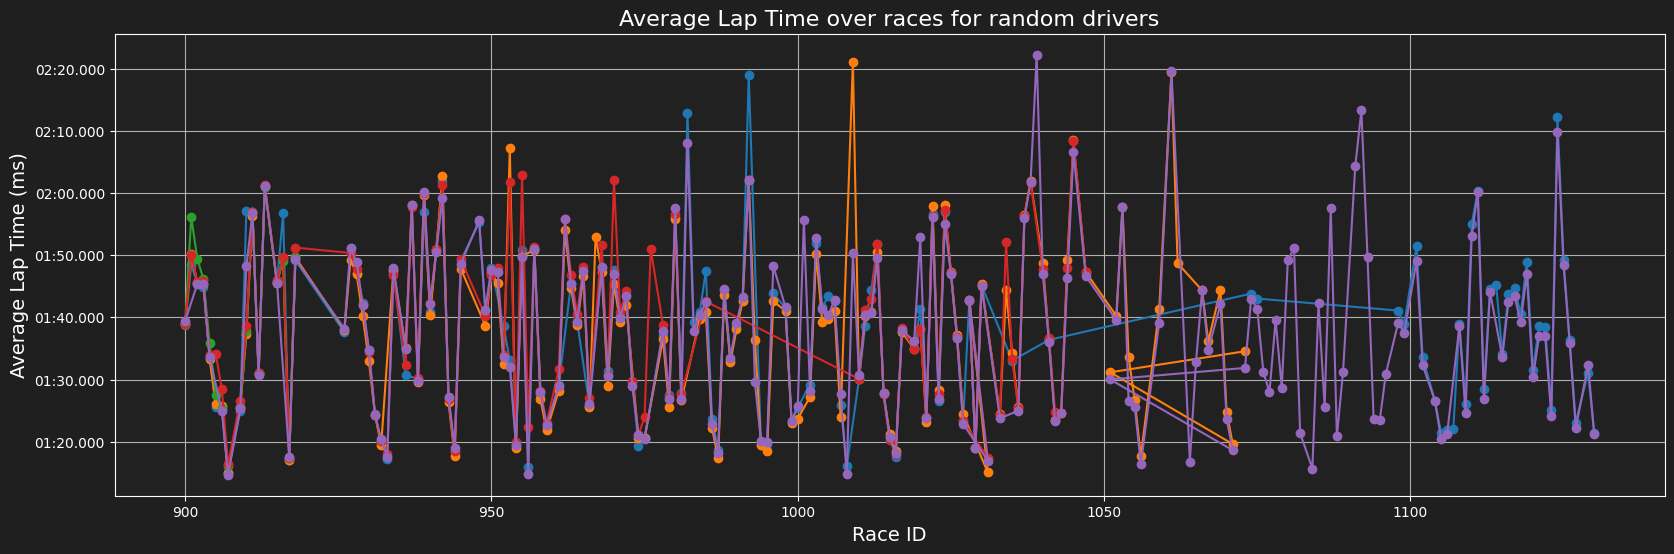

In [40]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(20, 6))

for driver_id in cleaned_df['driverId'].unique()[5:10]:
    driver_data = cleaned_df[cleaned_df['driverId'] == driver_id]
    plt.plot(driver_data['raceId'], driver_data['avg_lap_time'], marker='o', label=f'Driver {driver_id}')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ms_to_time))
plt.title('Average Lap Time over races for random drivers', fontsize=16)
plt.xlabel('Race ID', fontsize=14)
plt.ylabel('Average Lap Time (ms)', fontsize=14)
plt.grid(True)
plt.show()

In [41]:
df = cleaned_df.merge(status, on='statusId')
display(df)

,raceId,driverId,positionOrder,fastestLapMilliseconds,fastestLapSpeed,avg_lap_time,elo_rating,circuitId,statusId,status
0,900,3,1,92478.0,206.436,97872.105263,1778.820655,1,1,Finished
1,900,825,2,93066.0,205.131,98341.877193,1757.178055,1,1,Finished
2,900,18,3,92917.0,205.460,98398.894737,1735.290282,1,1,Finished
3,900,4,4,93186.0,204.867,98491.122807,1713.069319,1,1,Finished
4,900,822,5,92616.0,206.128,98707.877193,1690.430154,1,1,Finished
...,...,...,...,...,...,...,...,...,...,...
3792,1076,830,18,81677.0,232.633,94887.842105,1488.566529,1,95,Fuel leak
3793,1085,852,20,100216.0,209.858,104395.705882,1236.687359,34,140,Undertray
3794,1111,844,19,77277.0,198.408,87349.878049,1511.292561,39,140,Undertray
3795,1116,4,16,99954.0,198.559,103637.285714,1568.796901,69,140,Undertray


In [42]:
good_status = ["Finished", "Not restarted", "+1 Lap"] + [f"+{l} Laps" for l in range(2, 51)]
incident_status = ["Disqualified", "Accident", "Collision"]
print("Number of samples that have incident status:", len(df[df["status"].isin(incident_status)]))

Number of samples that have incident status: 131


In [43]:
drivers_in_incidents = df[df["status"].isin(incident_status)]["driverId"].unique()
print("IDs of drivers that have been incidents:")
print(drivers_in_incidents)

IDs of drivers that have been incidents:
[817 154 839 825 807  20   1 844 821  16 815  13 822   8   4 828 832 840
 838 836 830 843 846 826 842 847 849 841 855 856 858 848 820 813 835 854
 852]


In [44]:
finished_races = df[df["status"].isin(good_status)]
incidents_races = df[df["status"].isin(incident_status)]
old_races = pd.concat([finished_races, incidents_races], axis=0, ignore_index=True)
print("Successfully finished races:", len(finished_races))
print("Incidents:", len(incidents_races))

Successfully finished races: 3226
Incidents: 131


In [45]:
nan_per_column_finished = (finished_races == '\\N').sum()
nan_per_column_incidents = (incidents_races == '\\N').sum()
print(nan_per_column_finished)
print(nan_per_column_incidents)

raceId                     0
driverId                   0
positionOrder              0
fastestLapMilliseconds     0
fastestLapSpeed           17
avg_lap_time               0
elo_rating                 0
circuitId                  0
statusId                   0
status                     0
dtype: int64
raceId                    0
driverId                  0
positionOrder             0
fastestLapMilliseconds    0
fastestLapSpeed           9
avg_lap_time              0
elo_rating                0
circuitId                 0
statusId                  0
status                    0
dtype: int64


In [46]:
finished_races = finished_races.replace(r'\\N', np.nan, regex=True)
incidents_races = incidents_races.replace(r'\\N', np.nan, regex=True)

In [47]:
finished_races['fastestLapSpeed'] = pd.to_numeric(finished_races['fastestLapSpeed'], errors='coerce')
incidents_races['fastestLapSpeed'] = pd.to_numeric(incidents_races['fastestLapSpeed'], errors='coerce')

In [48]:
finished_races['fastestLapMilliseconds'] = finished_races.groupby('driverId')['fastestLapMilliseconds'].transform(lambda x: x.fillna(x.mean()))
incidents_races['fastestLapMilliseconds'] = incidents_races.groupby('driverId')['fastestLapMilliseconds'].transform(lambda x: x.fillna(x.mean()))

finished_races['fastestLapSpeed'] = finished_races.groupby('driverId')['fastestLapSpeed'].transform(lambda x: x.fillna(x.mean()))
incidents_races['fastestLapSpeed'] = incidents_races.groupby('driverId')['fastestLapSpeed'].transform(lambda x: x.fillna(x.mean()))

In [49]:
nan_per_column_finished = (finished_races == '\\N').sum()
nan_per_column_incidents = (incidents_races == '\\N').sum()
print(nan_per_column_finished)
print(nan_per_column_incidents)

raceId                    0
driverId                  0
positionOrder             0
fastestLapMilliseconds    0
fastestLapSpeed           0
avg_lap_time              0
elo_rating                0
circuitId                 0
statusId                  0
status                    0
dtype: int64
raceId                    0
driverId                  0
positionOrder             0
fastestLapMilliseconds    0
fastestLapSpeed           0
avg_lap_time              0
elo_rating                0
circuitId                 0
statusId                  0
status                    0
dtype: int64


## Divide into features and target

In [50]:
# positionOrder, fastestLapMilliseconds, fastestLapSpeed, avg_lap_time, elo_rating, cicuitId
features = finished_races[["positionOrder", "fastestLapMilliseconds", "fastestLapSpeed", "elo_rating", "circuitId"]]
display(features)

,positionOrder,fastestLapMilliseconds,fastestLapSpeed,elo_rating,circuitId
0,1,92478.0,206.436,1778.820655,1
1,2,93066.0,205.131,1757.178055,1
2,3,92917.0,205.460,1735.290282,1
3,4,93186.0,204.867,1713.069319,1
4,5,92616.0,206.128,1690.430154,1
...,...,...,...,...,...
3673,17,79098.0,196.116,1232.320215,18
3674,15,79868.0,150.413,1407.237323,6
3691,18,89285.0,233.575,1307.331542,14
3692,16,99368.0,211.649,1441.605539,34


In [51]:
target = finished_races[["avg_lap_time"]]
display(target)

,avg_lap_time
0,97872.105263
1,98341.877193
2,98398.894737
3,98491.122807
4,98707.877193
...,...
3673,81838.567164
3674,97051.081081
3691,92344.851064
3692,104490.744681


### Feature Visualations

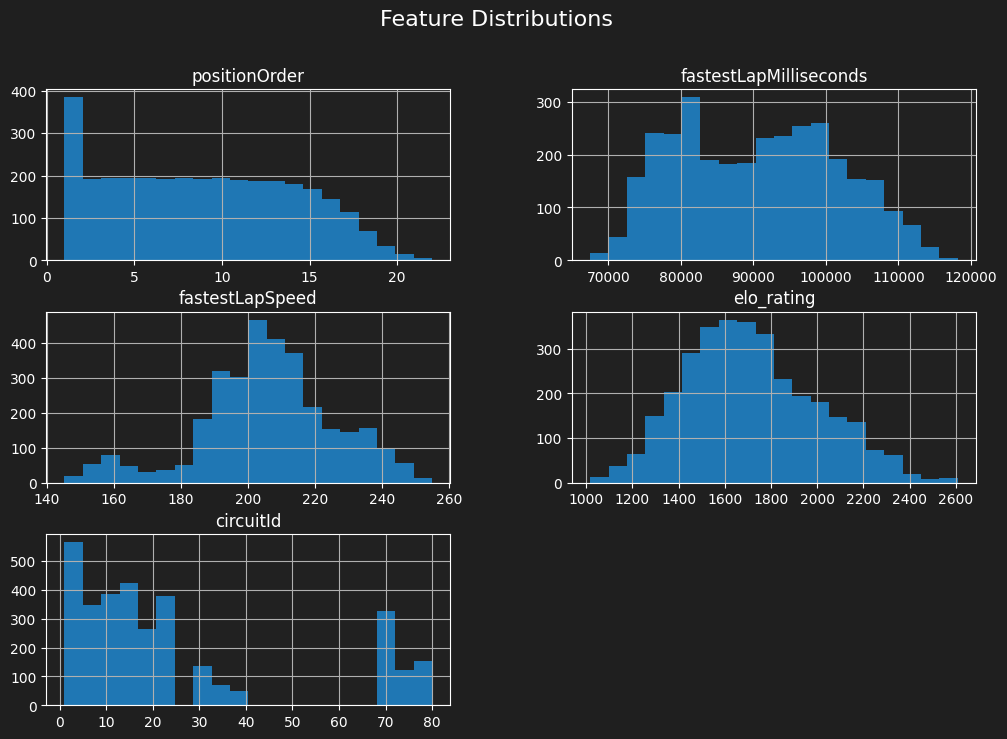

In [52]:
features.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

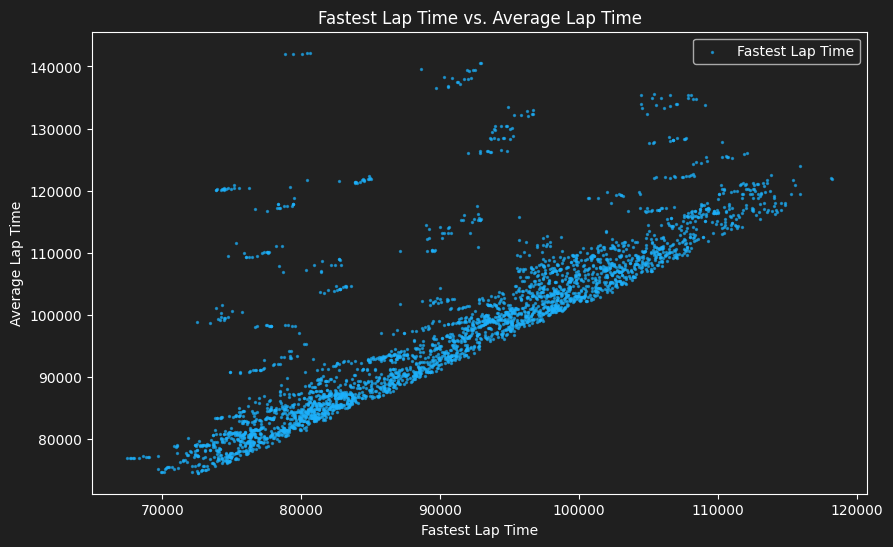

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(finished_races['fastestLapMilliseconds'], finished_races['avg_lap_time'], alpha=0.6, label='Fastest Lap Time', color=BLUE, s=2)
plt.xlabel("Fastest Lap Time")
plt.ylabel("Average Lap Time")
plt.legend()
plt.title("Fastest Lap Time vs. Average Lap Time")
plt.show()

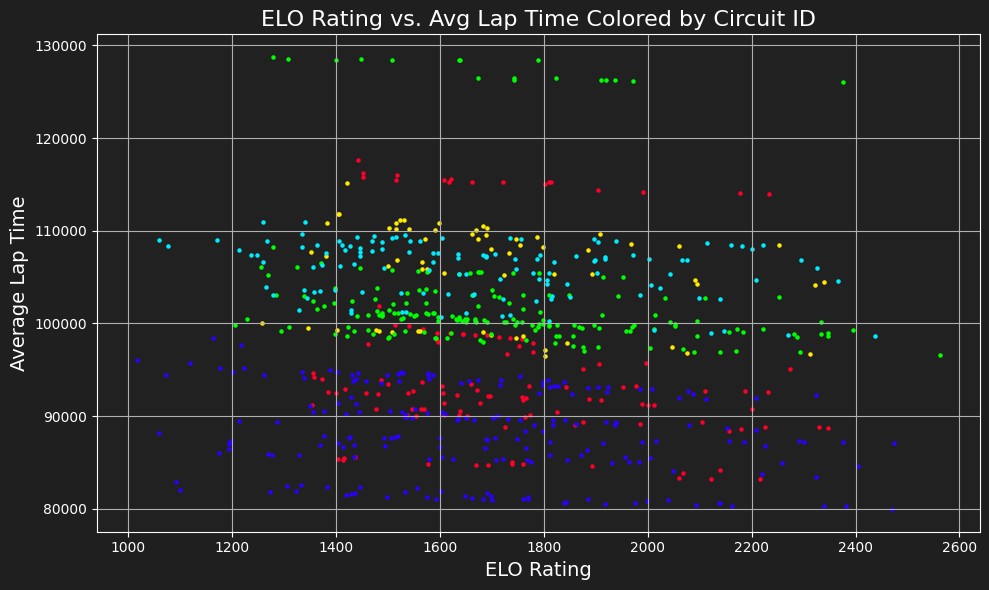

In [54]:
import matplotlib.pyplot as plt
import matplotlib

# Colors
unique_circuits = finished_races['circuitId'].unique()[:5]
circuit_colors = {circuit: matplotlib.colormaps['gist_rainbow'](i / len(unique_circuits)) for i, circuit in enumerate(unique_circuits)}

# Plot
plt.figure(figsize=(10, 6))

for circuit_id in unique_circuits:
    subset = finished_races[finished_races['circuitId'] == circuit_id]
    plt.scatter(
        subset['elo_rating'],
        subset['avg_lap_time'],
        color=circuit_colors[circuit_id],
        s=5,  # Size of points
        label=f'Circuit {circuit_id}'
    )

plt.xlabel('ELO Rating', fontsize=14)
plt.ylabel('Average Lap Time', fontsize=14)
plt.title('ELO Rating vs. Avg Lap Time Colored by Circuit ID', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


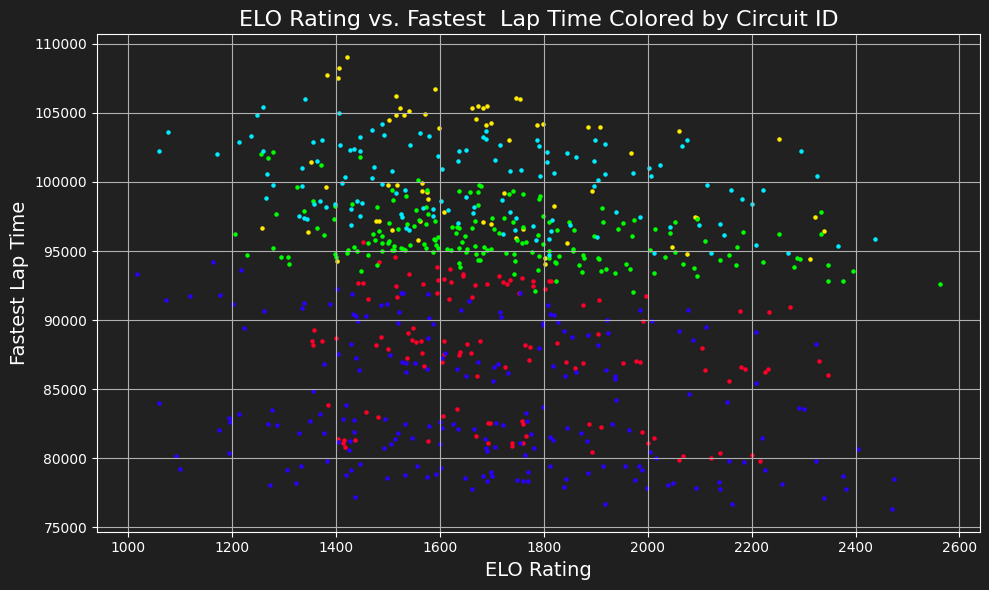

In [55]:
import matplotlib.pyplot as plt
import matplotlib

# Colors
unique_circuits = finished_races['circuitId'].unique()[:5]
circuit_colors = {circuit: matplotlib.colormaps['gist_rainbow'](i / len(unique_circuits)) for i, circuit in enumerate(unique_circuits)}

# Plot
plt.figure(figsize=(10, 6))

for circuit_id in unique_circuits:
    subset = finished_races[finished_races['circuitId'] == circuit_id]
    plt.scatter(
        subset['elo_rating'],
        subset['fastestLapMilliseconds'],
        color=circuit_colors[circuit_id],
        s=5,  # Size of points
        label=f'Circuit {circuit_id}'
    )

plt.xlabel('ELO Rating', fontsize=14)
plt.ylabel('Fastest Lap Time', fontsize=14)
plt.title('ELO Rating vs. Fastest  Lap Time Colored by Circuit ID', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


## Training a model

In [56]:
# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(normalized_features, target, test_size=0.2, random_state=42)

In [58]:
from sklearn.neural_network import MLPRegressor

# Define
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10000, random_state=42)

# Train
mlp.fit(X_train, y_train.values.ravel())

# Predict
y_pred = mlp.predict(X_test)

In [59]:
r2 = mlp.score(X_test, y_test)
print("Score: ", r2)

Score:  0.6627436089095065


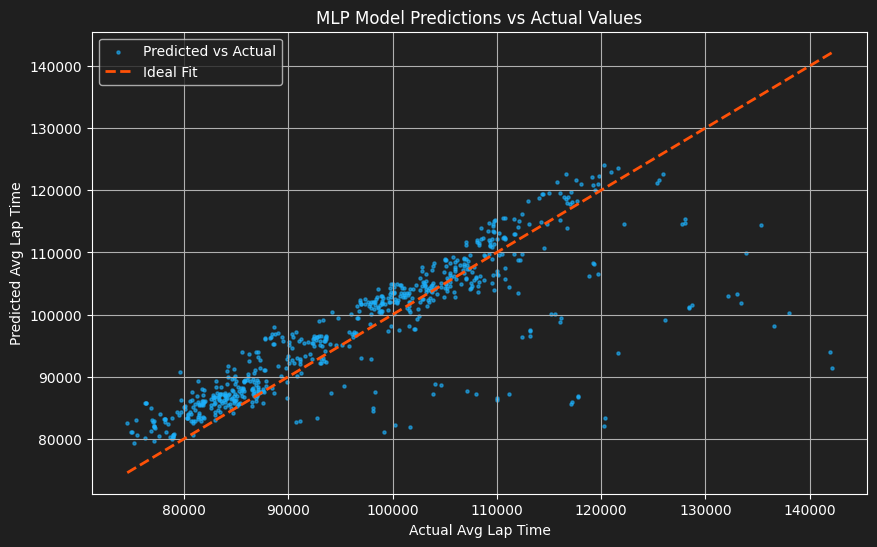

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, s=5, color=BLUE, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, label='Ideal Fit', color=RED)
plt.xlabel('Actual Avg Lap Time')
plt.ylabel('Predicted Avg Lap Time')
plt.title('MLP Model Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

## Use the MLP to predict the avg time for each incident

In [61]:
scaler = StandardScaler()
normalized_prediction_features = scaler.fit_transform(incidents_races[["positionOrder", "fastestLapMilliseconds", "fastestLapSpeed", "elo_rating", "circuitId"]])

In [62]:
predictions = mlp.predict(normalized_prediction_features)

In [63]:
# Add a 10sec penalty
predictions_with_penalty = predictions + 10000 // 60

#### Correct the average lap time using the new predictions

In [64]:
incidents_races['avg_lap_time'] = predictions_with_penalty

In [65]:
incidents_races

,raceId,driverId,positionOrder,fastestLapMilliseconds,fastestLapSpeed,avg_lap_time,elo_rating,circuitId,statusId,status
3271,900,817,22,101737.75,209.7245,105064.239782,1120.827073,1,2,Disqualified
3272,1002,154,20,101439.80,199.9994,104087.710728,1284.763577,14,2,Disqualified
3273,1006,839,19,81203.00,233.9910,87480.680530,1276.085676,69,2,Disqualified
3274,1006,825,20,101731.20,200.6678,100963.793862,1065.071162,69,2,Disqualified
3275,1026,817,19,93481.00,223.6300,97721.274284,1184.850397,22,2,Disqualified
...,...,...,...,...,...,...,...,...,...,...
3587,1119,846,20,119327.00,187.0790,119636.931603,1471.175290,80,3,Accident
3588,1122,840,19,95560.00,232.5910,98746.413777,1383.554115,77,3,Accident
3589,1123,847,17,80284.00,236.6690,90163.917783,1539.968230,1,3,Accident
3590,1129,815,18,78819.00,199.1850,86542.252235,1346.844421,7,3,Accident


### Merge the finished results with the incidents_races with corrected results

In [66]:
combined_races = pd.concat([finished_races, incidents_races], axis=0, ignore_index=True)
display(combined_races)

,raceId,driverId,positionOrder,fastestLapMilliseconds,fastestLapSpeed,avg_lap_time,elo_rating,circuitId,statusId,status
0,900,3,1,92478.0,206.436,97872.105263,1778.820655,1,1,Finished
1,900,825,2,93066.0,205.131,98341.877193,1757.178055,1,1,Finished
2,900,18,3,92917.0,205.460,98398.894737,1735.290282,1,1,Finished
3,900,4,4,93186.0,204.867,98491.122807,1713.069319,1,1,Finished
4,900,822,5,92616.0,206.128,98707.877193,1690.430154,1,1,Finished
...,...,...,...,...,...,...,...,...,...,...
3352,1119,846,20,119327.0,187.079,119636.931603,1471.175290,80,3,Accident
3353,1122,840,19,95560.0,232.591,98746.413777,1383.554115,77,3,Accident
3354,1123,847,17,80284.0,236.669,90163.917783,1539.968230,1,3,Accident
3355,1129,815,18,78819.0,199.185,86542.252235,1346.844421,7,3,Accident


## Compute new standings

In [67]:
def compute_standings(race_data, assign_zero_to_acc):
    race_ids = []
    finished_per_race = []
    result = pd.DataFrame()

    for race_id in sorted(race_data['raceId'].unique()):
        only_this_race = race_data[race_data['raceId'] == race_id].copy()
        only_this_race['points'] = 0

        # Deal with incidents
        only_this_race['is_incident'] = False
        if assign_zero_to_acc:
            only_this_race['is_incident'] = only_this_race['status'].isin(incident_status)
            only_this_race.loc[only_this_race['is_incident'], 'points'] = 0

        points = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1] + [0] * max(0, len(only_this_race) - 10)

        only_this_race = only_this_race.sort_values(by=['is_incident', 'avg_lap_time'])

        cutoff = len(only_this_race.head(10).index)
        only_this_race.loc[only_this_race.head(10).index, 'points'] = points[:cutoff]

        # Append for statistics
        race_ids.append(race_id)
        finished_per_race.append(len(only_this_race[only_this_race['is_incident'] == False]))
        
        result = pd.concat([result, only_this_race], axis=0, ignore_index=True)

    return result, race_ids, finished_per_race

In [68]:
print("Length of old dataset:", len(old_races))
print("Length of new dataset:", len(combined_races))

Length of old dataset: 3357
Length of new dataset: 3357


In [69]:
old_standings, old_race_ids, old_finished_per_race = compute_standings(old_races, True)
new_standings, new_race_ids, new_finished_per_race = compute_standings(combined_races, False)

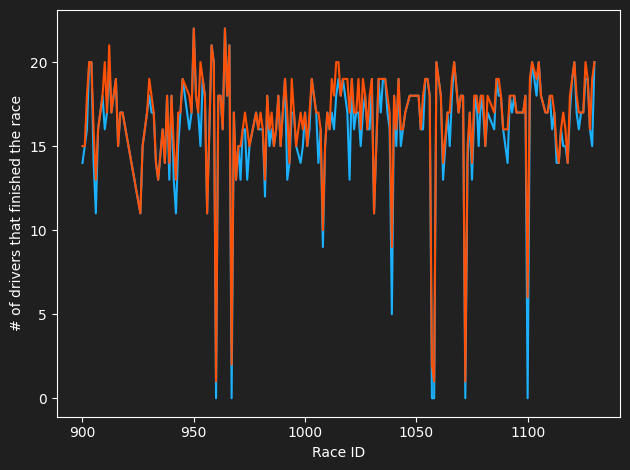

In [70]:
plt.plot(old_race_ids, old_finished_per_race, color=BLUE, label='Old')
plt.plot(new_race_ids, new_finished_per_race, color=RED, label='New')
plt.xlabel("Race ID")
plt.ylabel("# of drivers that finished the race")
plt.tight_layout()
plt.show()

In [71]:
old_standings

,raceId,driverId,positionOrder,fastestLapMilliseconds,fastestLapSpeed,avg_lap_time,elo_rating,circuitId,statusId,status,points,is_incident
0,900,3,1,92478.0,206.436,97872.105263,1778.820655,1,1,Finished,25,False
1,900,825,2,93066.0,205.131,98341.877193,1757.178055,1,1,Finished,18,False
2,900,18,3,92917.0,205.460,98398.894737,1735.290282,1,1,Finished,15,False
3,900,4,4,93186.0,204.867,98491.122807,1713.069319,1,1,Finished,12,False
4,900,822,5,92616.0,206.128,98707.877193,1690.430154,1,1,Finished,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3352,1130,822,16,79608.0,210.596,82362.153846,1445.482841,4,11,+1 Lap,0,False
3353,1130,825,17,79805.0,210.077,82384.846154,1382.666128,4,11,+1 Lap,0,False
3354,1130,848,18,79132.0,211.863,82436.553846,1305.434057,4,11,+1 Lap,0,False
3355,1130,852,19,79447.0,211.023,82525.092308,1332.148929,4,11,+1 Lap,0,False


In [72]:
new_standings

,raceId,driverId,positionOrder,fastestLapMilliseconds,fastestLapSpeed,avg_lap_time,elo_rating,circuitId,statusId,status,points,is_incident
0,900,3,1,92478.0,206.436,97872.105263,1778.820655,1,1,Finished,25,False
1,900,825,2,93066.0,205.131,98341.877193,1757.178055,1,1,Finished,18,False
2,900,18,3,92917.0,205.460,98398.894737,1735.290282,1,1,Finished,15,False
3,900,4,4,93186.0,204.867,98491.122807,1713.069319,1,1,Finished,12,False
4,900,822,5,92616.0,206.128,98707.877193,1690.430154,1,1,Finished,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3352,1130,822,16,79608.0,210.596,82362.153846,1445.482841,4,11,+1 Lap,0,False
3353,1130,825,17,79805.0,210.077,82384.846154,1382.666128,4,11,+1 Lap,0,False
3354,1130,848,18,79132.0,211.863,82436.553846,1305.434057,4,11,+1 Lap,0,False
3355,1130,852,19,79447.0,211.023,82525.092308,1332.148929,4,11,+1 Lap,0,False


In [73]:
merged_standings = pd.merge(old_standings[['raceId', 'driverId', 'points']], 
                             new_standings[['raceId', 'driverId', 'points']], 
                             on=['raceId', 'driverId'], 
                             how='outer', 
                             suffixes=('_old', '_new'))
display(merged_standings)

,raceId,driverId,points_old,points_new
0,900,3,25,25
1,900,825,18,18
2,900,18,15,15
3,900,4,12,12
4,900,822,10,10
...,...,...,...,...
3352,1130,822,0,0
3353,1130,825,0,0
3354,1130,848,0,0
3355,1130,852,0,0


In [74]:
accumulated_points = merged_standings.groupby('driverId')[['points_old', 'points_new']].sum().reset_index()
accumulated_points = accumulated_points.sort_values(by='points_new', ascending=False)
accumulated_points = accumulated_points.merge(elo_last_names_df, on='driverId')
accumulated_points['elo_rating'] = accumulated_points['elo_rating'].round(decimals=0).astype(int)
display(accumulated_points)

,driverId,points_old,points_new,elo_rating,forename,surname,count
0,1,3198,3020,2263,Lewis,Hamilton,215
1,830,2452,2373,2275,Max,Verstappen,197
2,822,1572,1584,1463,Valtteri,Bottas,216
3,20,1510,1460,1683,Sebastian,Vettel,180
4,815,1280,1227,1508,Sergio,Pérez,214
5,817,1123,1128,1636,Daniel,Ricciardo,201
6,844,1047,1057,1609,Charles,Leclerc,137
7,832,988,930,2040,Carlos,Sainz,196
8,3,944,907,2343,Nico,Rosberg,59
9,8,872,838,1219,Kimi,Räikkönen,158


In [75]:
acc2 = accumulated_points.copy()
acc2['ratio'] = acc2['points_new'] / acc2['points_old']
print(acc2['ratio'].std())

4.541305085781469


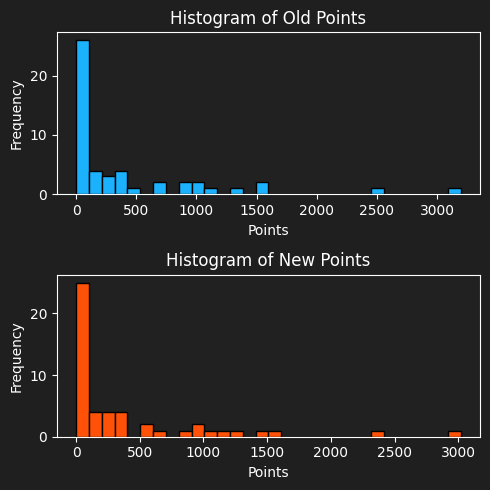

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(5, 5))

axs[0].hist(accumulated_points['points_old'], bins=30, color=BLUE, edgecolor='black')
axs[0].set_title('Histogram of Old Points')
axs[0].set_xlabel('Points')
axs[0].set_ylabel('Frequency')

axs[1].hist(accumulated_points['points_new'], bins=30, color=RED, edgecolor='black')
axs[1].set_title('Histogram of New Points')
axs[1].set_xlabel('Points')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [77]:
normal_old = is_normal(accumulated_points['points_old'])
normal_new = is_normal(accumulated_points['points_new'])
print(f"Is Normal results: {normal_old} {normal_new}")

Is Normal results: False False


### Using the Wilcoxon test for paired variables to check statistical significance

In [78]:
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(accumulated_points['points_old'], accumulated_points['points_new'])
print(f"Wilcoxon Signed-Rank Test p-value: {p_value}")
if p_value <= 0.05:
    print("Statistically significant.")
else:
    print("Statistically insignificant.")

Wilcoxon Signed-Rank Test p-value: 0.726212920190495
Statistically insignificant.


Elo vs old points cor: 0.71
Elo vs new points cor: 0.68


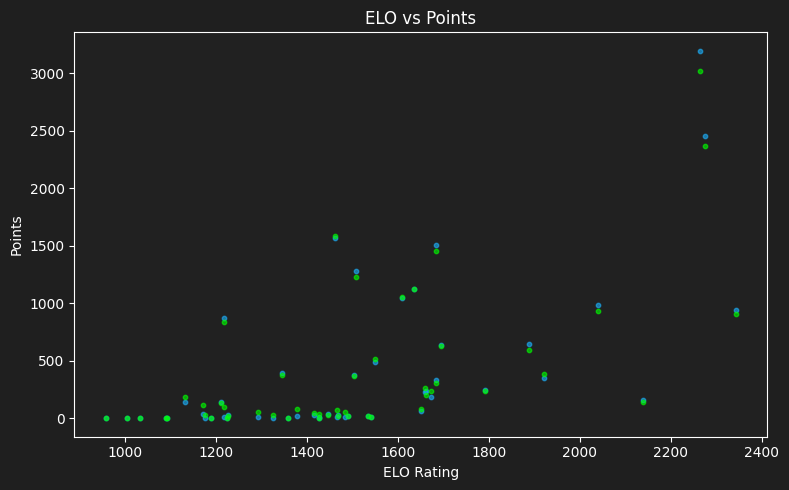

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

spearman_old, _ = spearmanr(accumulated_points['elo_rating'], accumulated_points['points_old'])
spearman_new, _ = spearmanr(accumulated_points['elo_rating'], accumulated_points['points_new'])

print(f"Elo vs old points cor: {spearman_old:.2f}")
print(f"Elo vs new points cor: {spearman_new:.2f}")

plt.figure(figsize=(8, 5))

plt.scatter(accumulated_points['elo_rating'], accumulated_points['points_old'], color=BLUE, alpha=0.6, s=10, label='old')
plt.scatter(accumulated_points['elo_rating'], accumulated_points['points_new'], color=GREEN, alpha=0.6, s=10, label='new')
plt.title('ELO vs Points')
plt.xlabel('ELO Rating')
plt.ylabel('Points')
plt.tight_layout()
plt.show()

In [80]:
old_championship = old_standings.merge(races[['raceId', 'year']], on='raceId')
new_championship = new_standings.merge(races[['raceId', 'year']], on='raceId')

old_championship = old_championship.groupby(['year', 'driverId'])['points'].sum().reset_index()
new_championship = new_championship.groupby(['year', 'driverId'])['points'].sum().reset_index()

In [81]:
merge_championship = pd.merge(old_championship[['year', 'driverId', 'points']], 
                             new_championship[['year', 'driverId', 'points']], 
                             on=['year', 'driverId'], 
                             how='outer', 
                             suffixes=('_old', '_new'))
display(merge_championship)

,year,driverId,points_old,points_new
0,2014,1,291,278
1,2014,3,274,266
2,2014,4,157,152
3,2014,8,58,54
4,2014,13,123,113
...,...,...,...,...
230,2024,848,6,24
231,2024,852,13,11
232,2024,855,0,0
233,2024,857,82,74


In [82]:
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(merge_championship['points_old'], merge_championship['points_new'])
print(f"Wilcoxon Signed-Rank Test p-value: {p_value}")
if p_value <= 0.05:
    print("Statistically significant.")
else:
    print("Statistically insignificant.")

Wilcoxon Signed-Rank Test p-value: 0.244028581510498
Statistically insignificant.
